In [1]:
import datetime as dt

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Portfolio 2: Data driven prediction models of energy use of appliances in a low-energy house
This notebook is a partial replication of the analysis exploring appliance energy consumption based on the research by Luis M. Candanedo, Véronique Feldheim and Dominique Deramaix. The research paper discusses how various variables, such as temperature, humidity and other weather parameters, can predict appliance energy consumption using different machine learning methods. Linear regression, support vector machines, random forests and gradient boosting machines were used for prediction and recursive feature elimination (RFE) was used to rank the predictor variable importance. This notebook will focus on the replication of the multiple linear regression method with RFE to select relevant features.


## Loading the Data
The dataset is collected from a house in Stambruges designed to have low energy consumption. The energy (Wh) data is recorded every 10 minutes to capture quick changes in energy consumption in the house. Lights energy consumption is also collected using a sub-metered load. Temperature and humidity reading are also taken from each room in the house. All these information were taken for 137 days and combined to form the energy dataset. We proceed with conducting exploratory analysis on this data. 

In [2]:
energy = pd.read_csv('data/energydata_complete.csv')
energy.date = pd.to_datetime(energy.date)
print('Dimensions of the energy dataset: ', energy.shape)
energy.head()

Dimensions of the energy dataset:  (19735, 29)


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


The dataset contains 19,735 observations and 29 variables (2 of which are random variables and will be removed from our dataset later on). The description of the data can be found below.

## Data Description
Data variables and their description are listed below. We remove variables `rv1` and `rv2` as these are random variables that were not used in the prediction.
* __date__ - date and time when the observation was taken
* __Appliances__ - Appliances energy consumption
* __lights__ - Light energy consumption
* __T1__ - Temperature in kitchen area
* __RH_1__ - Humidity in kitchen area
* __T2__ - Temperature in living room area
* __RH_2__ - Humidity in living room area
* __T3__ - Temperature in laundry room area
* __RH_3__ - Humidity in laundry room area
* __T4__ Temperature in office room
* __RH_4__ - Humidity in office room
* __T5__ - Temperature in bathroom
* __RH_5__ - Humidity in bathroom
* __T6__ - Temperature outside the building (north side)
* __RH_6__ - Humidity outside the building (north side)
* __T7__ - Temperature in ironing room
* __RH_7__ - Humidity in ironing room
* __T8__ - Temperature in teenager room 2
* __RH_8__ - Humidity in teenager room 2
* __T9__ - Temperature in parents room
* __RH_9__ - Humidity in parents room
* __T_out__ - Temperature outside (from Chièvres weather station)
* __Press_mm_hg__ - Pressure (from Chièvres weather station)
* __RH_out__ - Humidity outside (from Chièvres weather station)
* __Windspeed__ - Windspeed (from Chièvres weather station)
* __Visibility__ - Visibility (from Chièvres weather station)
* __Tdewpoint__ - Tdewpoint (from Chièvres weather station)

In [3]:
energy = energy.drop(['rv1', 'rv2'], axis = 1)
energy.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


In [4]:
print('Dimensions of complete energy dataset: ', energy.shape)

Dimensions of complete energy dataset:  (19735, 27)


We create extra features (number of seconds from midnight, week status and day of the week) to be included when fitting multiple linear regression model. Week status and day of the week are transformed as categorical variables and we impose ordering on the day of the week variable setting Sunday as the start of the week:
* NSM - number of seconds from midnight
* week_status - weekday or weekend
* day - day of the week

In [5]:
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
energy['NSM'] = energy.date.apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
energy['week_status'] = energy.date.apply(lambda x: 'weekend' if (x.weekday() == 5 | x.weekday() == 6) else 'weekday').astype('category')
energy['day'] = energy.date.dt.day_name().astype('category')

## A Look at Energy Appliance Usage
We look at the overall trend of energy consumption of appliances for the entire period in the dataset.

/Users/jvlpz/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Energy Consumption')

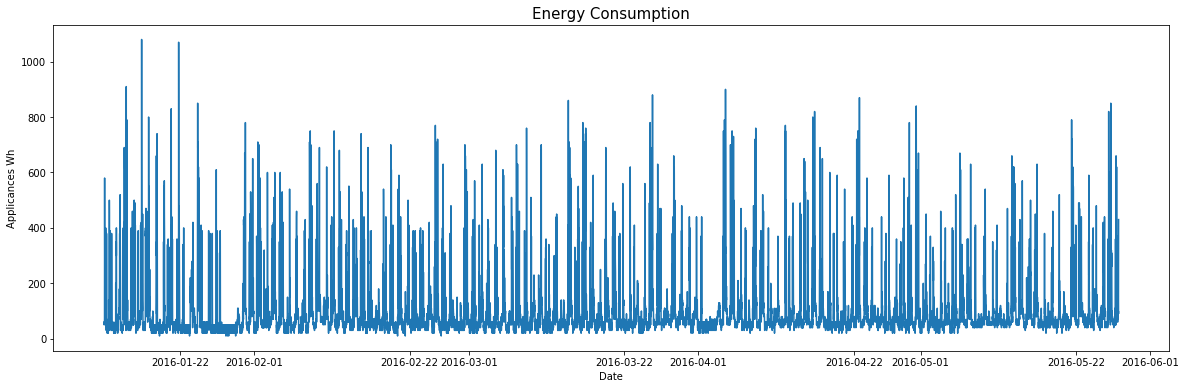

In [6]:
plt.figure(figsize = (20,6))
sns.lineplot(x = 'date', y = 'Appliances', data = energy).set(xlabel = 'Date', ylabel = 'Applicances Wh')
plt.title('Energy Consumption', size = 15)

We can observe multiple spikes in the data which means increased energy consumption during certain dates. We also take a closer look at the first week of data below.

Text(0.5, 1.0, 'Energy Consumption for Week 1')

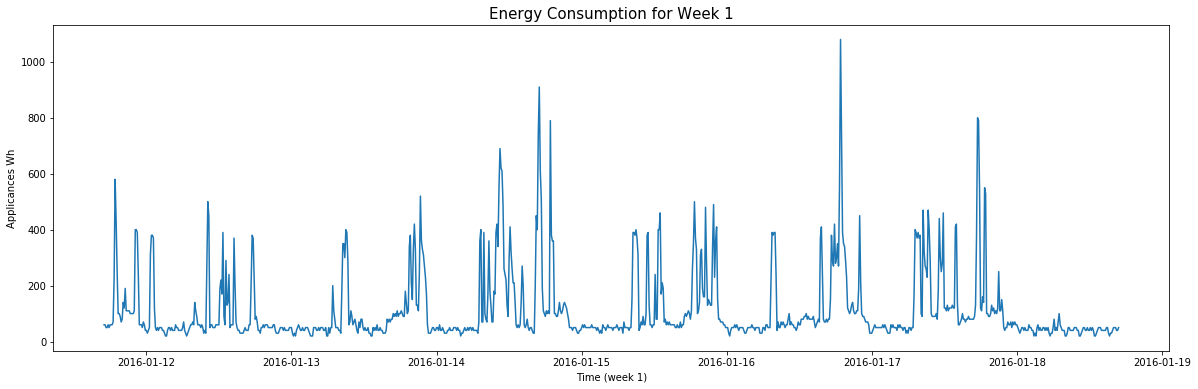

In [7]:
plt.figure(figsize = (20, 6))
sns.lineplot(x = energy.date[0:1008], y = energy.Appliances[0:1008]).set(xlabel = 'Time (week 1)', ylabel = 'Applicances Wh')
plt.title('Energy Consumption for Week 1', size = 15)

count    19735.000000
mean        97.694958
std        102.524891
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1080.000000
Name: Appliances, dtype: float64

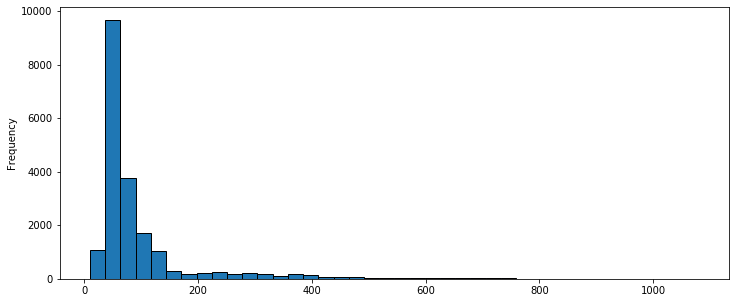

In [8]:
plt.figure(figsize=(12, 5))
energy.Appliances.plot.hist(edgecolor = 'black', bins = 40)
energy.Appliances.describe()

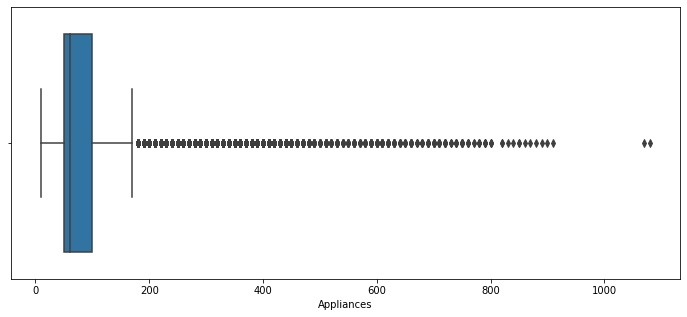

In [9]:
plt.figure(figsize=(12, 5))
sns.boxplot(energy.Appliances)

The energy consumption data is highly skewed to the right, as seen on the histogram and boxplots below, having average Wh higher than the median Wh. The average energy consumption is 97.69 Wh and 50% of the data have higher than 60 Wh usage.

## A Quick Glance at Hourly Energy Consumption
We transform our dataset to round down to the nearest hour and aggregate the energy consumption by date and hour. We also create a weekday and week number variable for exploratory data analysis.

In [10]:
energy['mhr'] = energy.date.apply(lambda x: x.replace(second = 0, minute = 0))
energy_total_per_hour = pd.DataFrame(energy.groupby('mhr').sum().Appliances).reset_index()
energy_total_per_hour['day'] = energy_total_per_hour.mhr.dt.day_name().astype('category', categories = days, ordered = True)
energy_total_per_hour['week_no'] = (energy_total_per_hour.mhr + dt.timedelta(days = 3)).dt.week
energy_total_per_hour.head()

/Users/jvlpz/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


,mhr,Appliances,day,week_no
0,2016-01-11 17:00:00,330,Monday,2
1,2016-01-11 18:00:00,1060,Monday,2
2,2016-01-11 19:00:00,1040,Monday,2
3,2016-01-11 20:00:00,750,Monday,2
4,2016-01-11 21:00:00,620,Monday,2


In [11]:
def weekly_heatmap(n, idx):
    df = energy_total_per_hour[energy_total_per_hour.week_no == n]
    df['hour'] = df.mhr.apply(lambda x: x.hour)
    fig = sns.heatmap(df.pivot('hour', 'day', 'Appliances'), cmap = 'YlOrRd', ax = axs[idx], vmax = 3600,
                      cbar_kws = {'shrink': 0.75, 'label': 'Appliances', 'orientation': 'horizontal'}).invert_yaxis()
    return fig

A subset (weeks 3 to 6) of the aggregated energy consumption by date and hour is plotted below using a heatmap with the day of the week on the x-axis and the hour of the day (0 being midnight) on the y-axis.

/Users/jvlpz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


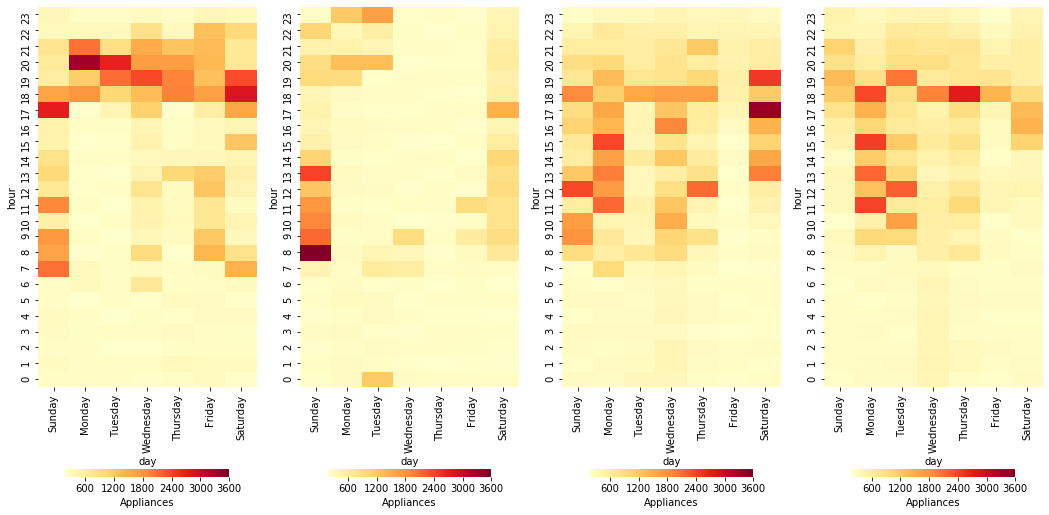

In [12]:
fig, axs = plt.subplots(ncols = 4, figsize=(18,10))

weekly_heatmap(3, 0)
weekly_heatmap(4, 1)
weekly_heatmap(5, 2)
weekly_heatmap(6, 3)

High energy consumption can be observed during the afernoon and night time, as well as the weekends which might be due to more appliance usage in the house as most family members are home during these times.

## Correlation Pair Plots between Appliances Energy Consumption
Next, we explore the correlation between the energy consumption of appliances and the rest of the variables. We'll define functions to speed up the creation of scatterplot and correlation matrices.

In [13]:
plot1_cols = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3']
plot2_cols = ['Appliances', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6']
plot3_cols = ['Appliances', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9']
plot4_cols = ['Appliances', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'NSM']

In [14]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha = 0.6, cmap = "coolwarm",
               vmin = -1, vmax = 1, transform = ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords = "axes fraction",
                ha = 'center', va = 'center', fontsize = font_size)

def corr_plot(cols):
    df = energy[cols]
    fig = sns.PairGrid(df)
    fig.map_diag(plt.hist, bins = 15, edgecolor = "black")
    fig.map_lower(plt.scatter, edgecolor = "white", )
    fig.map_upper(corrdot)
    return fig

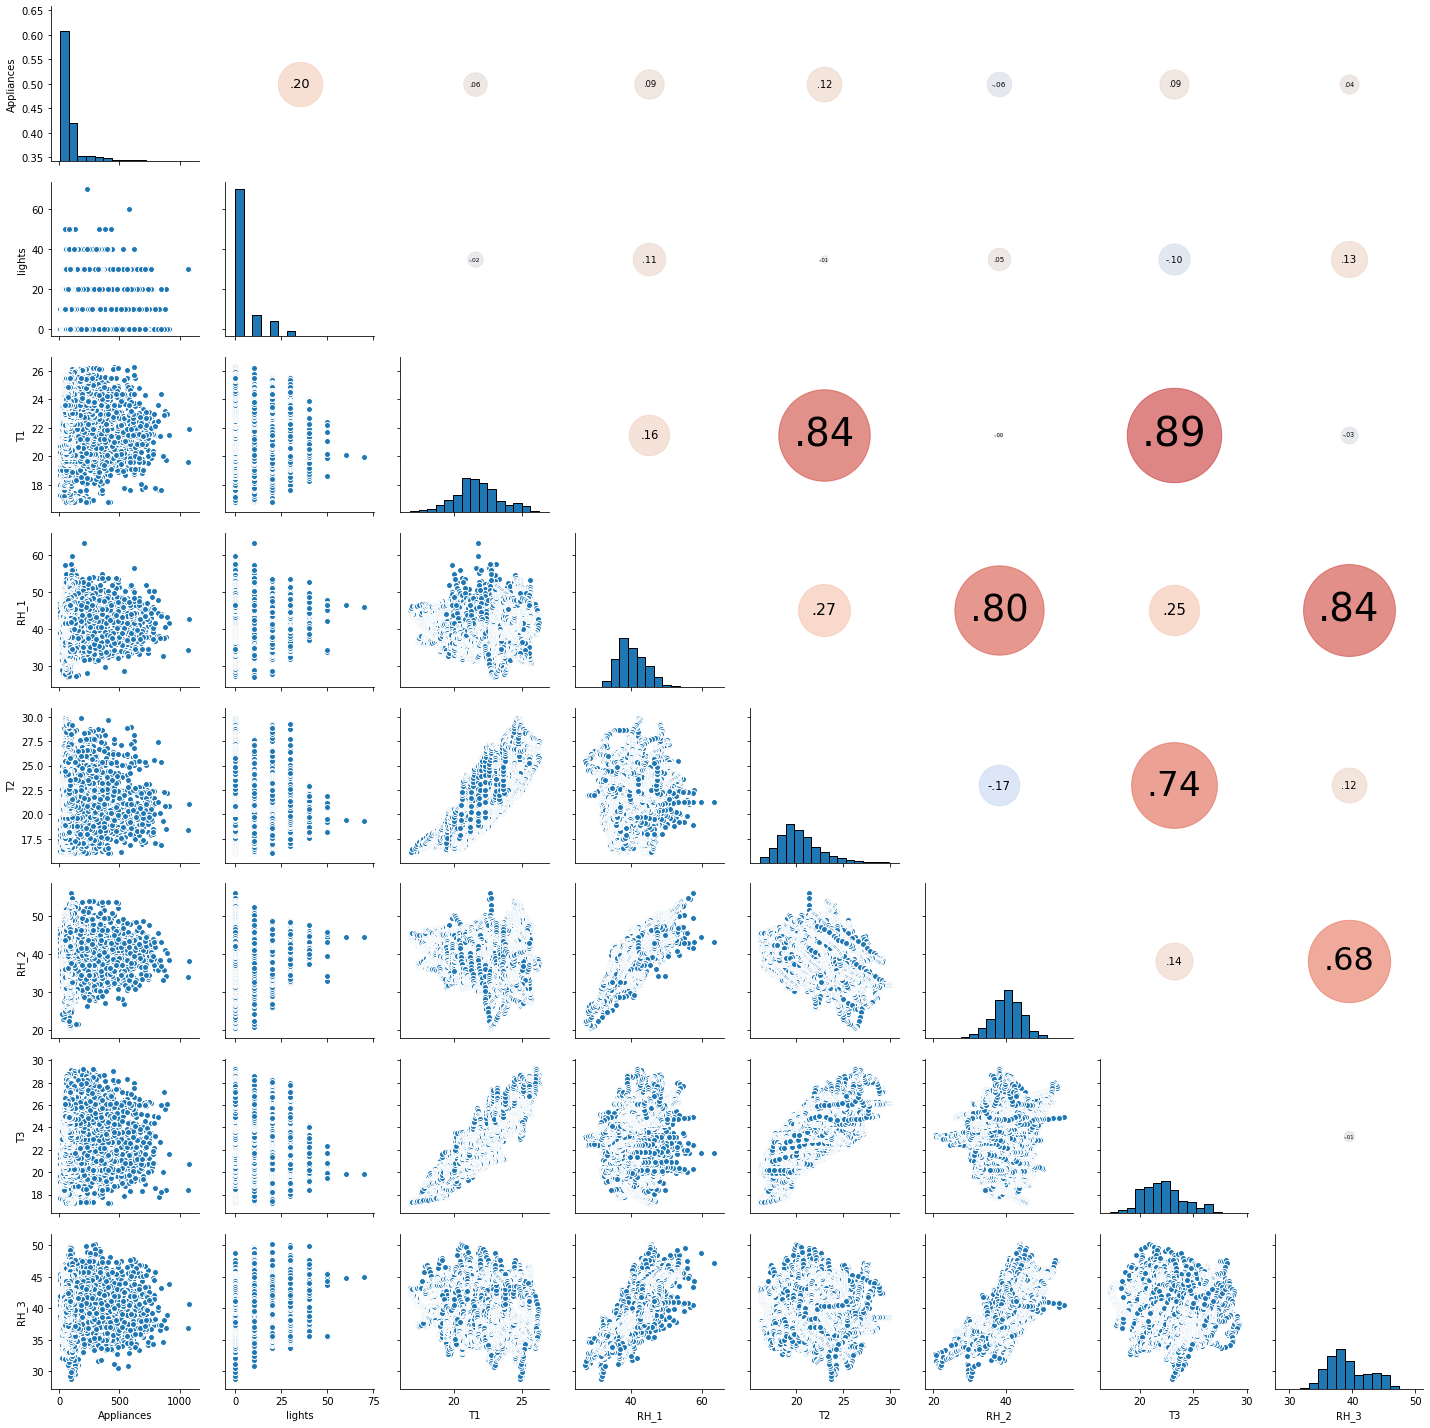

In [15]:
corr_plot(plot1_cols)

The correlation and scatter plot matrix above shows that there is a positive correlation between appliance energy consumption and lights, which means that higher appliance energy consumption is associated with higher lights consumption. The second largest correlation is between appliances and the temperature in the living room (T2). High positive correlation can be observed on temperature variable pairs and humidity variable pairs. The correlation and scatter plot matrices between energy consumption and the rest of the variables are presented on the succeeding cells.

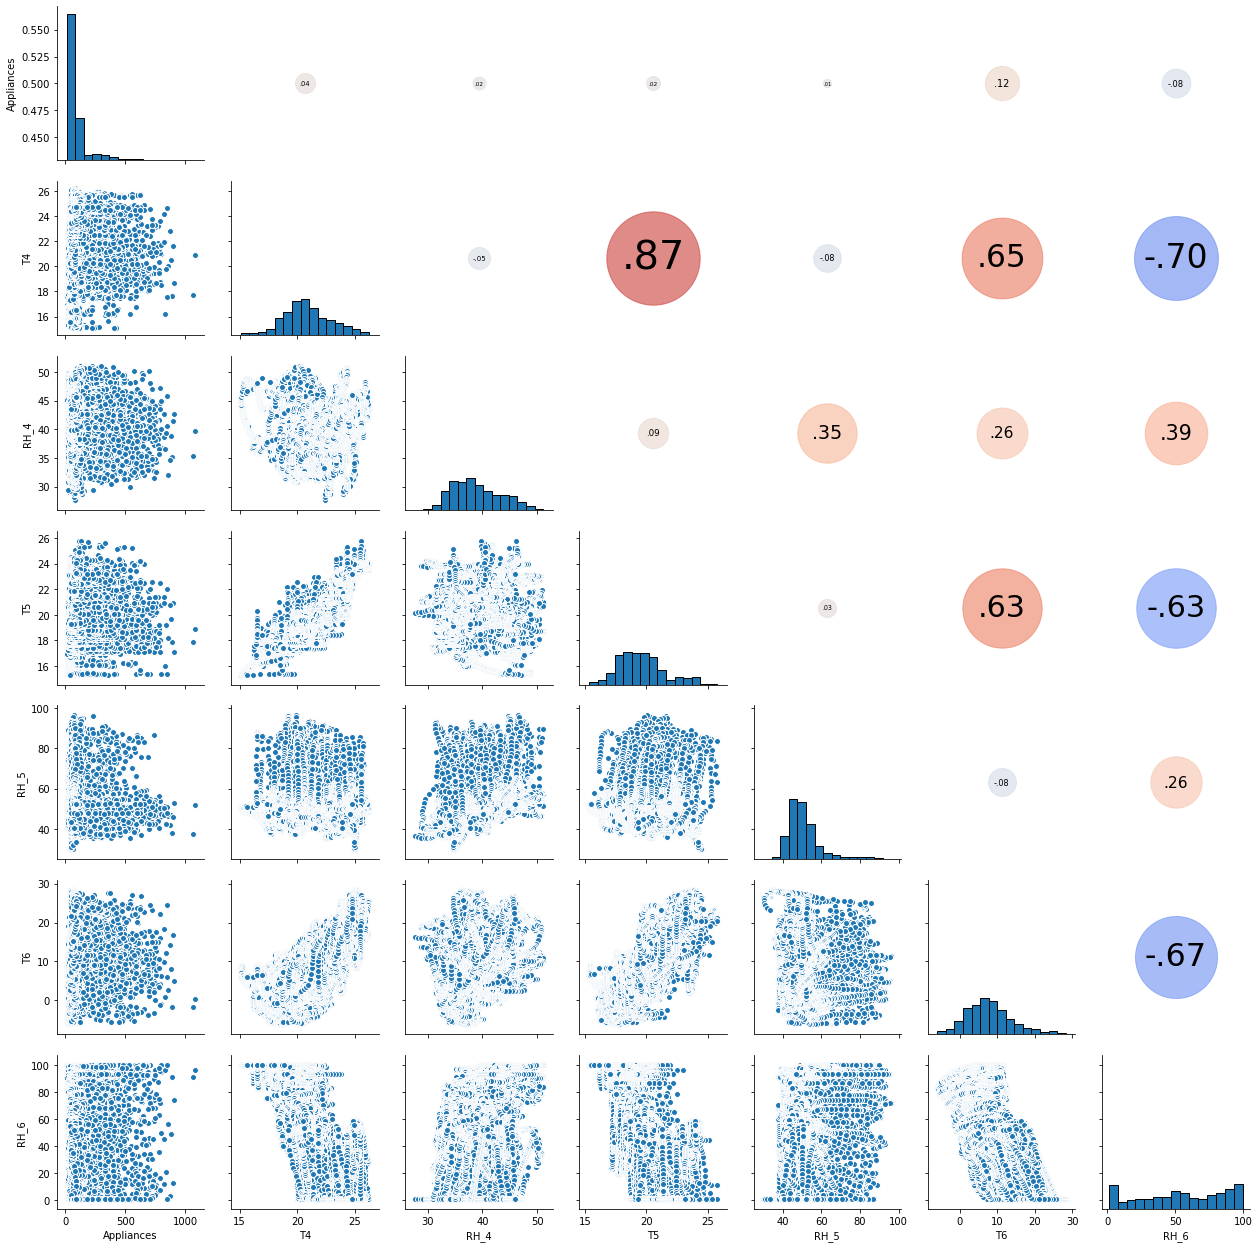

In [16]:
corr_plot(plot2_cols)

There is a positive correlation between energy consumption and outside temperature (T6). A negative correlation can be observed between energy consumption and outside humidity (RH_6). As observed on the previous plot matrix, a positive correlation can be observed on the temprature variable pairs, as well as humidity variable pairs.

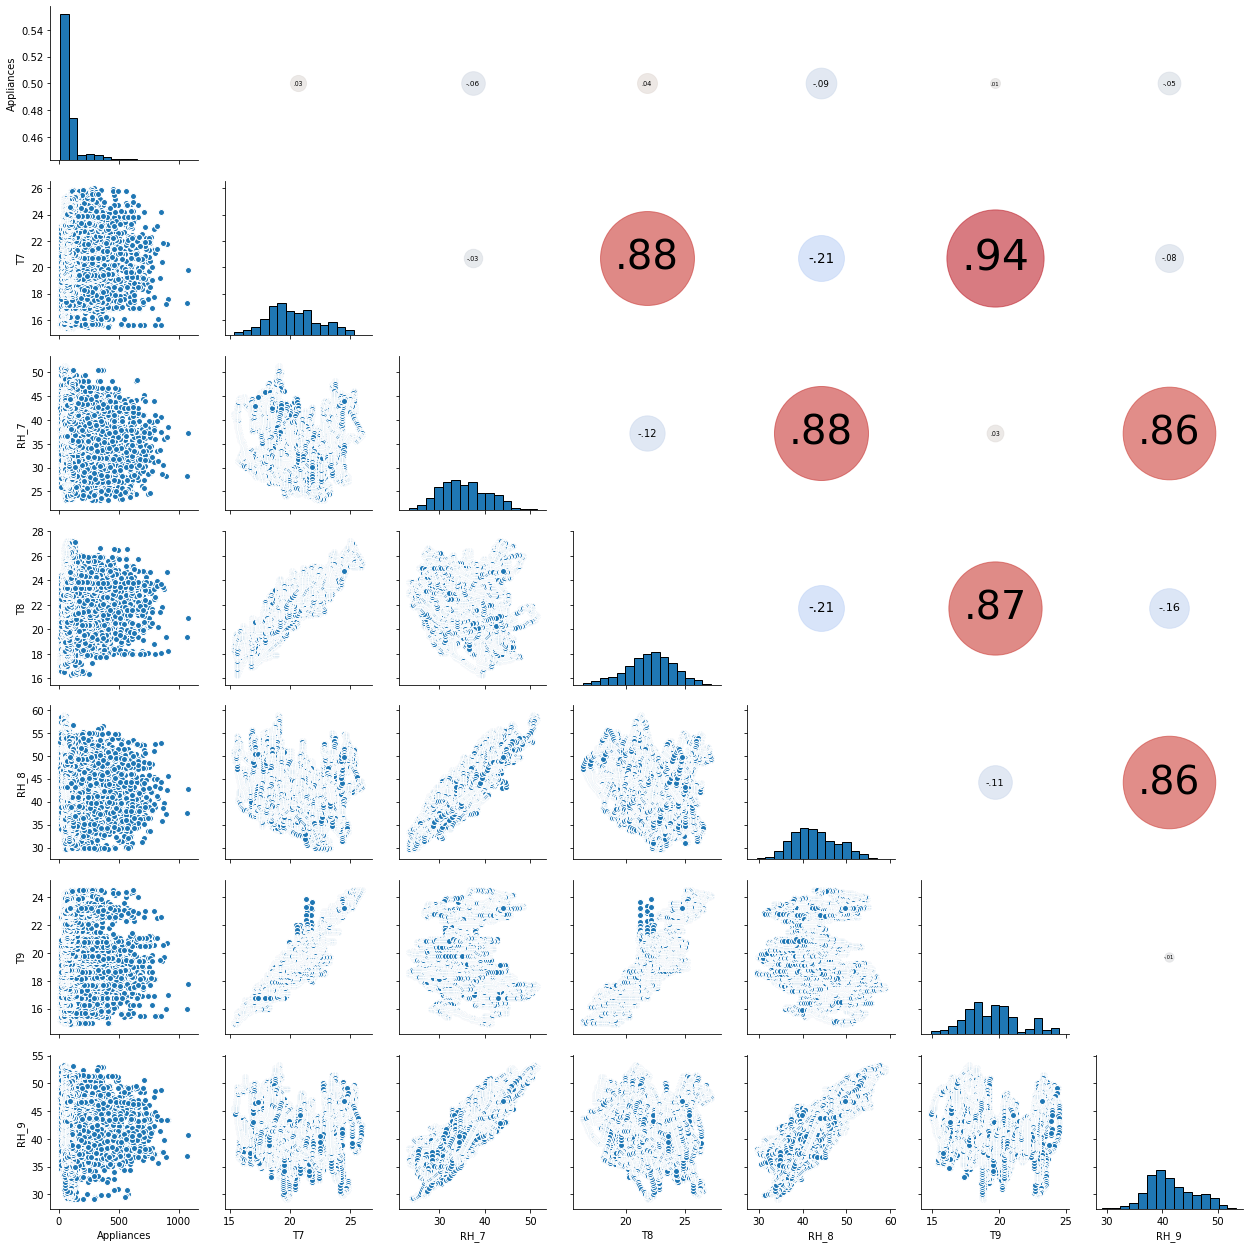

In [17]:
corr_plot(plot3_cols)

A positive correlation can be observed between energy consumption and the temperature in the ironing room (T7), the temperature in the teenager's room (T8) and the temperature in the parents' room. Again, temperature variable pairs and humidity variable pairs are also highly positively correlated.

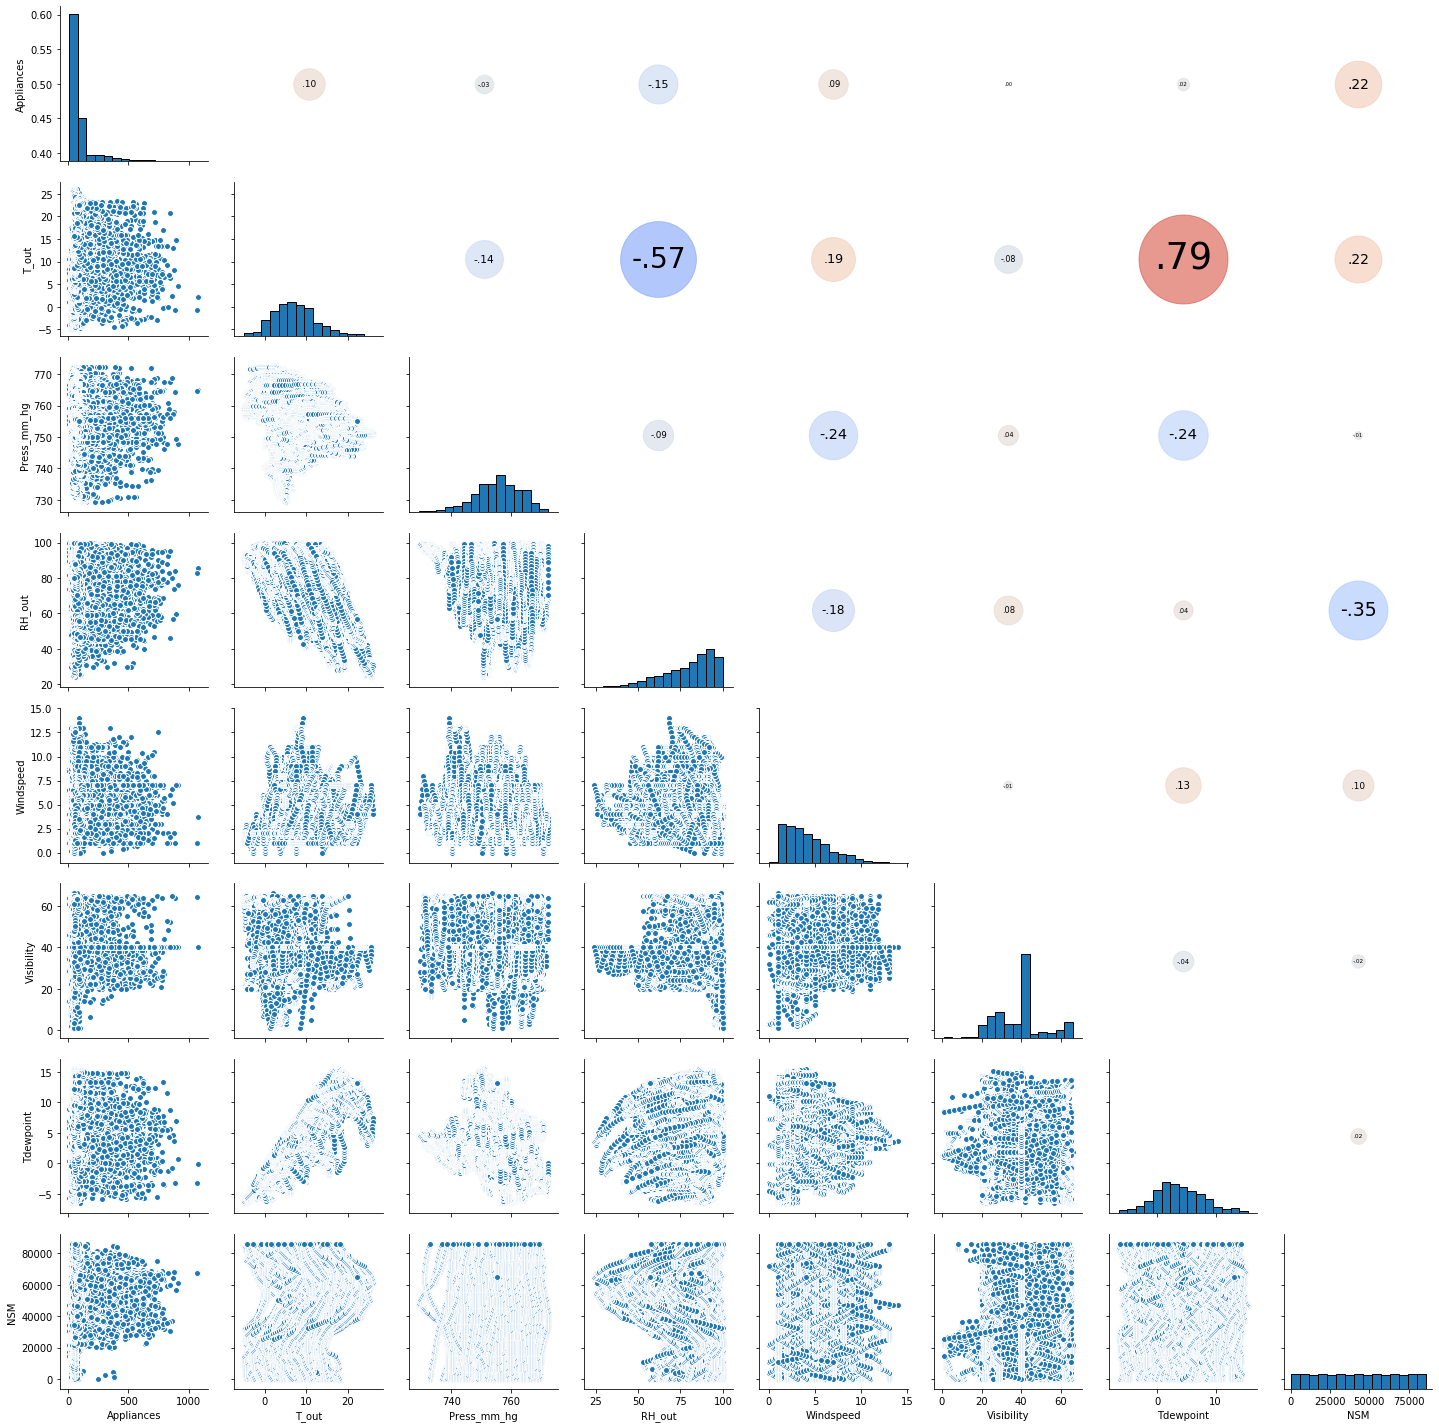

In [18]:
corr_plot(plot4_cols)

The number of seconds from midnight (NSM) has the highest positive correlation with applianced energy consumption. 

## Data Preparation for Multiple Regression Modelling with Recursive Feature Elimination
The training-test split is 75-25 which means the training dataset contains 14,803 observations and  testing dataset with 4,932 observations. We transform the week status and day of the week variables to categorical data and convert them to dummy variables in preparation for fitting the multiple linear regression. We also set the weekday value and Sunday value as reference variables for the week status and day of the week variables dummy data, respectively. We drop the variables `rv1` and `rv2` from our datasets since they are random variables.

In [19]:
train = pd.read_csv('data/training.csv')
train.date = pd.to_datetime(train.date)
test = pd.read_csv('data/testing.csv')
test.date = pd.to_datetime(train.date)
train = train.drop(['rv1', 'rv2'], axis = 1)
test = test.drop(['rv1', 'rv2'], axis = 1)
print("Dimensions of training dataset: ", train.shape)
print("Dimensions of testing dataset: ", test.shape)

Dimensions of training dataset:  (14803, 30)
Dimensions of testing dataset:  (4932, 30)


In [20]:
train['WeekStatus'] = train.WeekStatus.astype('category')
test['WeekStatus'] = test.WeekStatus.astype('category')
train['Day_of_week'] = train.Day_of_week.astype('category', categories = days, ordered = True)
test['Day_of_week'] = test.Day_of_week.astype('category', categories = days, ordered = True)

In [21]:
train_WeekStatus = pd.get_dummies(train.WeekStatus, drop_first = True)
test_WeekStatus = pd.get_dummies(test.WeekStatus, drop_first = True)
train_Day_of_week = pd.get_dummies(train.Day_of_week, drop_first = True)
test_Day_of_week = pd.get_dummies(test.Day_of_week, drop_first = True)
train = train.join(train_WeekStatus, how = "inner")
train = train.join(train_Day_of_week, how = "inner")
test = test.join(test_WeekStatus, how = "inner")
test = test.join(test_Day_of_week, how = "inner")

In [22]:
train = train.drop(['WeekStatus', 'Day_of_week'], axis = 1)
train.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Visibility,Tdewpoint,NSM,Weekend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,63.000000,5.3,61200,0,1,0,0,0,0,0
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,59.166667,5.2,61800,0,1,0,0,0,0,0
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,55.333333,5.1,62400,0,1,0,0,0,0,0
3,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,47.666667,4.9,63600,0,1,0,0,0,0,0
4,2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,...,43.833333,4.8,64200,0,1,0,0,0,0,0


In [23]:
test = test.drop(['WeekStatus', 'Day_of_week'], axis = 1)
test.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Visibility,Tdewpoint,NSM,Weekend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,2016-01-11 17:00:00,50,40,19.890000,46.066667,19.200000,44.590000,19.79,45.000000,18.89,...,51.5,5.000000,63000,0,1,0,0,0,0,0
1,2016-01-11 17:10:00,60,50,19.890000,45.766667,19.200000,44.500000,19.79,44.900000,18.89,...,40.0,4.700000,64800,0,1,0,0,0,0,0
2,2016-01-11 17:20:00,230,70,19.926667,45.863333,19.356667,44.400000,19.79,44.900000,18.89,...,40.0,4.633333,67200,0,1,0,0,0,0,0
3,2016-01-11 17:40:00,580,60,20.066667,46.396667,19.426667,44.400000,19.79,44.826667,19.00,...,40.0,4.616667,67800,0,1,0,0,0,0,0
4,2016-01-11 17:50:00,100,10,20.566667,53.893333,20.033333,46.756667,20.10,48.466667,19.00,...,40.0,4.350000,70200,0,1,0,0,0,0,0


Finally, we specify the independent variables and the dependent variable that we will use when fitting the model. There are a total of 33 independent variables that we will use to predict the energy consumption through multiple regression model. We will simulate different number of covariates in the model by using the recursive feature elimination method to reduce the number of variables to the most important ones only.

In [24]:
X_cols = list(train.columns.drop(['date', 'Appliances']))
y_col = 'Appliances'
X_train = train[X_cols]
y_train = train[y_col]
X_test = test[X_cols]
y_test = test[y_col]

In [25]:
print('Dimension of X_train: ', X_train.shape)
print('Dimension of y_train: ', y_train.shape)
print('Dimension of X_test: ', X_test.shape)
print('Dimension of y_test: ', y_test.shape)

Dimension of X_train:  (14803, 33)
Dimension of y_train:  (14803,)
Dimension of X_test:  (4932, 33)
Dimension of y_test:  (4932,)


## Multiple Regression Model Training with Different Number of Predictors

We develop the multiple linear models with recursive feature elimination in the following section. We start with using only the top 5 most important predictors and increase the number of predictors by 5 in each iteration until we have included all predictors. In each of the model built, we will display the linear equation and the most important variables that were included in the model.

Prior to starting with building the multiple regression models, we define several functions that we will use for the rest of the analysis:

1. The `rfe_mlr` function provides a method to run the multiple linear regression algorithm with the recursive feature elimination.
2. The `list_rfe_pred` function displays the top `n` features selected by the RFE algorithm.
3. The `model_assess` function provides several model assessment metrics to compare the performance of each regression runs. The `print_assess` function displays the model assessment metrics results in each model. The following are used to assess the models:
    * __Root Mean Square Error__ (RMSE) is the square root of the variance of the residuals and measures how close/far the predicted values are from the actual values. Lower values of RMSE indicate that the predicted values are close to the actual values.
    * __Coefficient of Determination__ ($R^2$) measures how much of the variation in the response variable is explained by the linear model. Higher values of $R^2$ mean that the model explains most of the variability on the response variable.
    * __Mean Absolute Error__ (MAE) measures the average magnitude of deviation of the predicted values from the actual values without considering the direction of the error.
    * __Mean Absolute Percentage Error__ (MAPE) measures the average deviation of the predicted values from the actual values as a percentage.
    
The comparison of assessment metrics for all the models built will be discussed in the last part of the notebook.

In [26]:
def rfe_mlr(n, df_X, df_y):
    model = linear_model.LinearRegression()
    rfe = RFE(estimator = model, n_features_to_select = n, step = 1)
    rfe.fit(df_X, df_y)
    return rfe

def list_rfe_pred(model, df_X):
    features_bool = np.array(model.support_)
    features = np.array(df_X.columns)
    result = features[features_bool]
    return result

def model_assess(model, df_X, df_y):
    y_pred = model.predict(df_X)
    rmse = np.sqrt(((np.array(df_y) - y_pred)**2).sum() / len(df_y))
    r2 = r2_score(df_y, y_pred)
    mae = np.mean(abs((df_y - y_pred)))
    mape = np.mean(abs((df_y - y_pred) / df_y)) * 100
    return rmse, r2, mae, mape

def print_assess(model):
    print('RMSE: ', model[0])
    print('R-squared: ', model[1])
    print('Mean Absolute Error: ', model[2])
    print('Mean Absolute Percentage Error: ', model[3])

## Train Multiple Linear Regression Using 5 Most Important Variable

In [27]:
model5 = rfe_mlr(5, X_train, y_train)
print(list_rfe_pred(model5, X_train))

['RH_1' 'T2' 'RH_2' 'T3' 'Monday']


In [28]:
print("y = x *", model5.estimator_.coef_, "+", model5.estimator_.intercept_)

y = x * [ 19.42964585 -21.99191421 -19.93549145  18.09426842  13.10502611] + 163.98990561799167


Recursive feature algorithm has selected the following top 5 most impotant variables to be included in the model:
* kitchen humidity (RH_1)
* living room temperature (T2)
* living room humidity (RH_2)
* laundry room temperature (T3)
* Monday dummy variable (Monday)

### Assessing the Model on Training and Testing Dataset (5 Best Predictors)

In [29]:
model5_train_assess = model_assess(model5, X_train, y_train)
print_assess(model5_train_assess)

RMSE:  98.03949637444838
R-squared:  0.09090652238803942
Mean Absolute Error:  58.09424481326967
Mean Absolute Percentage Error:  71.5803343868902


In [30]:
model5_test_assess = model_assess(model5, X_test, y_test)
print_assess(model5_test_assess)

RMSE:  97.8787777388879
R-squared:  0.07198025464301383
Mean Absolute Error:  56.62988482233168
Mean Absolute Percentage Error:  69.63293227457307


## Train Multiple Linear Regression Using 10 Most Important Variable

In [31]:
model10 = rfe_mlr(10, X_train, y_train)
print(list_rfe_pred(model10, X_train))

['RH_1' 'T2' 'RH_2' 'T3' 'T8' 'RH_8' 'T9' 'Monday' 'Friday' 'Saturday']


In [32]:
print("y = x *", model10.estimator_.coef_, "+", model10.estimator_.intercept_)

y = x * [ 19.42674368 -12.86809623 -13.46086313  23.71033697   9.01043391
  -5.98461574 -23.37644956  14.462186    13.22100319  18.89599627] + 100.87057734084114


The following 5 variables were added as most important variables (on top of the 5 variables stated above) and were included in creation of the model:
* teenager's room temperature (T8)
* teenager's room humidity (RH_8)
* parents' room temperature (T9)
* Friday dummy variable (Friday)
* Saturday dummy variable (Saturday)

### Assessing the Model on Training and Testing Dataset (10 Best Predictors)

In [33]:
model10_train_assess = model_assess(model10, X_train, y_train)
print_assess(model10_train_assess)

RMSE:  95.2334633730318
R-squared:  0.1422009597443512
Mean Absolute Error:  54.16099668526507
Mean Absolute Percentage Error:  63.41034270141491


In [34]:
model10_test_assess = model_assess(model10, X_test, y_test)
print_assess(model10_test_assess)

RMSE:  95.04617607469439
R-squared:  0.12491661191575232
Mean Absolute Error:  52.71066575069968
Mean Absolute Percentage Error:  61.6491199458991


## Train Multiple Linear Regression Using 15 Most Important Variable

In [35]:
model15 = rfe_mlr(15, X_train, y_train)
print(list_rfe_pred(model15, X_train))

['RH_1' 'T2' 'RH_2' 'T3' 'RH_3' 'T6' 'T8' 'RH_8' 'T9' 'T_out' 'Monday'
 'Tuesday' 'Thursday' 'Friday' 'Saturday']


In [36]:
print("y = x *", model15.estimator_.coef_, "+", model15.estimator_.intercept_)

y = x * [ 16.91712633 -18.14925372 -14.16643357  24.14993638   5.91150563
   6.04890301  11.82985876  -6.75950867 -22.86800603  -5.29081629
  10.69939111  -6.45314955  -4.59550365  11.95655142  16.55213327] + 51.27516044333392


The following 5 variables were added as most important variables (on top of the 10 variables stated above) and were included in creation of the model:
* laundry room humidity (RH_3)
* temperature outside the building (T6)
* temperature outside (from weather station) (T_out)
* Tuesday dummy variable (Tuesday)
* Thursday dummy variable (Thursday)

### Assessing the Model on Training and Testing Dataset (15 Best Predictors)

In [37]:
model15_train_assess = model_assess(model15, X_train, y_train)
print_assess(model15_train_assess)

RMSE:  94.74081714345569
R-squared:  0.1510528571205575
Mean Absolute Error:  54.111842827035794
Mean Absolute Percentage Error:  63.70311480945067


In [38]:
model15_test_assess = model_assess(model15, X_test, y_test)
print_assess(model15_test_assess)

RMSE:  94.68431856934916
R-squared:  0.13156712061088804
Mean Absolute Error:  52.80595714685305
Mean Absolute Percentage Error:  61.952778069711556


## Train Multiple Linear Regression Using 20 Most Important Variable

In [39]:
model20 = rfe_mlr(20, X_train, y_train)
print(list_rfe_pred(model20, X_train))

['lights' 'T1' 'RH_1' 'T2' 'RH_2' 'T3' 'RH_3' 'T6' 'RH_7' 'T8' 'RH_8' 'T9'
 'T_out' 'Windspeed' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday'
 'Saturday']


In [40]:
print("y = x *", model20.estimator_.coef_, "+", model20.estimator_.intercept_)

y = x * [  2.00608255  -3.76086189  15.34984826 -17.01613045 -13.59121462
  24.35566676   6.20548505   5.90589538  -1.47605436   9.80646357
  -5.20451753 -16.69565747  -5.31516504   1.73792697   4.85692424
  -8.44337978  -5.12342324  -5.56614619  13.15047689  16.62693377] + 31.842356511565995


The following 5 variables were added as most important variables (on top of the 15 variables stated above) and were included in creation of the model:
* light energy consumption (lights)
* kitchen temperature (T1)
* ironing room humidity (RH_7)
* windspeed (from weather station) (Windspeed)
* Wednesday dummy variable (Wednesday)

### Assessing the Model on Training and Testing Dataset (20 Best Predictors)

In [41]:
model20_train_assess = model_assess(model20, X_train, y_train)
print_assess(model20_train_assess)

RMSE:  93.44959349975872
R-squared:  0.17403578521951757
Mean Absolute Error:  53.264090357624596
Mean Absolute Percentage Error:  61.36610007463241


In [42]:
model20_test_assess = model_assess(model20, X_test, y_test)
print_assess(model20_test_assess)

RMSE:  93.29369806417367
R-squared:  0.15688899404690926
Mean Absolute Error:  52.0435349167842
Mean Absolute Percentage Error:  59.93206643746938


## Train Multiple Linear Regression Using 25 Most Important Variable

In [43]:
model25 = rfe_mlr(25, X_train, y_train)
print(list_rfe_pred(model25, X_train))

['lights' 'T1' 'RH_1' 'T2' 'RH_2' 'T3' 'RH_3' 'T5' 'T6' 'T7' 'RH_7' 'T8'
 'RH_8' 'T9' 'RH_9' 'T_out' 'Windspeed' 'Tdewpoint' 'Weekend' 'Monday'
 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday']


In [44]:
print("y = x *", model25.estimator_.coef_, "+", model25.estimator_.intercept_)

y = x * [  1.97507276  -3.83559432  15.31223233 -16.88550846 -13.84256667
  24.55940416   6.8508383   -0.82002521   5.71111893   1.29635931
  -1.6811772    9.2812778   -5.00602161 -17.08648494  -0.81805578
  -5.69377607   1.85555477   1.13326664   0.40682642   5.51062794
  -8.35077265  -5.0642284   -5.28235437  12.77990106  16.56219322] + 53.84059444701212


The following 5 variables were added as most important variables (on top of the 20 variables stated above) and were included in creation of the model:
* bathroom temperature (T5)
* ironing room temperature (T7)
* parents' room humidity (RH_9)
* Tdewpoint (from weather station) (Tdewpoint)
* weekend dummy variable (Weekend)

### Assessing the Model on Training and Testing Dataset (25 Best Predictors)

In [45]:
model25_train_assess = model_assess(model25, X_train, y_train)
print_assess(model25_train_assess)

RMSE:  93.4268109316125
R-squared:  0.17443846845195932
Mean Absolute Error:  53.19346168254047
Mean Absolute Percentage Error:  61.27138211502101


In [46]:
model25_test_assess = model_assess(model25, X_test, y_test)
print_assess(model25_test_assess)

RMSE:  93.3248817812589
R-squared:  0.15632527474736035
Mean Absolute Error:  52.02423852826069
Mean Absolute Percentage Error:  59.89604005172939


## Train Multiple Linear Regression Using 30 Most Important Variable

In [47]:
model30 = rfe_mlr(30, X_train, y_train)
print(list_rfe_pred(model30, X_train))

['lights' 'T1' 'RH_1' 'T2' 'RH_2' 'T3' 'RH_3' 'T4' 'T5' 'T6' 'RH_6' 'T7'
 'RH_7' 'T8' 'RH_8' 'T9' 'RH_9' 'T_out' 'Press_mm_hg' 'RH_out' 'Windspeed'
 'Visibility' 'Tdewpoint' 'Weekend' 'Monday' 'Tuesday' 'Wednesday'
 'Thursday' 'Friday' 'Saturday']


In [48]:
print("y = x *", model30.estimator_.coef_, "+", model30.estimator_.intercept_)

y = x * [  1.94290884  -4.39841065  15.16579083 -17.35599317 -13.88456284
  25.60342909   6.49000317   0.54481653  -0.50018062   6.6382181
   0.2944557    1.28874777  -1.62575955   9.33024488  -4.98954663
 -15.99119412  -1.11476818  -9.96111189   0.17464299  -1.02125135
   1.72675781   0.18248413   4.9230191    1.06820614   5.32521402
  -8.61881019  -4.86671029  -5.23567182  12.32777212  16.66098599] + -19.09938744195675


The following 5 variables were added as most important variables (on top of the 25 variables stated above) and were included in creation of the model:
* office room temperature (T4)
* humidity outside (RH_6)
* pressure (from weather station) (Press_mm_hg)
* humidity outside (from weather station) (RH_out)
* visibility (from weather station) (Visibility)

### Assessing the Model on Training and Testing Dataset (30 Best Predictors)

In [49]:
model30_train_assess = model_assess(model30, X_train, y_train)
print_assess(model30_train_assess)

RMSE:  93.34689033201167
R-squared:  0.17585029341753777
Mean Absolute Error:  53.17076583609735
Mean Absolute Percentage Error:  61.30486435032356


In [50]:
model30_test_assess = model_assess(model30, X_test, y_test)
print_assess(model30_test_assess)

RMSE:  93.29808618950878
R-squared:  0.15680967971270277
Mean Absolute Error:  52.04583943459271
Mean Absolute Percentage Error:  59.98923927309118


## Train Multiple Linear Regression Using All Variables

In [51]:
model_all = rfe_mlr(35, X_train, y_train)
print(list_rfe_pred(model_all, X_train))

['lights' 'T1' 'RH_1' 'T2' 'RH_2' 'T3' 'RH_3' 'T4' 'RH_4' 'T5' 'RH_5' 'T6'
 'RH_6' 'T7' 'RH_7' 'T8' 'RH_8' 'T9' 'RH_9' 'T_out' 'Press_mm_hg' 'RH_out'
 'Windspeed' 'Visibility' 'Tdewpoint' 'NSM' 'Weekend' 'Monday' 'Tuesday'
 'Wednesday' 'Thursday' 'Friday' 'Saturday']


In [52]:
print("y = x *", model_all.estimator_.coef_, "+", model_all.estimator_.intercept_)

y = x * [ 1.85514349e+00 -5.91623712e+00  1.45115663e+01 -1.78907829e+01
 -1.38360616e+01  2.63682598e+01  6.28860382e+00  9.24488963e-01
 -4.84922719e-01 -1.46004124e+00  6.80289266e-02  7.07362501e+00
  2.90309897e-01  1.41094452e+00 -1.62558312e+00  8.34559362e+00
 -4.13546815e+00 -1.30500097e+01 -3.80092173e-01 -9.70071004e+00
  1.80488089e-01 -7.82451548e-01  1.78827983e+00  1.87709260e-01
  3.63247626e+00  2.88265474e-04  1.29517599e+00  5.65557106e+00
 -8.48582427e+00 -5.00934073e+00 -5.26637963e+00  1.18107976e+01
  1.63015281e+01] + -75.2181843328019


The last 3 variables added in our final iteration which includes all predictor variables are:
* office room humidity (RH_4)
* bathroom humidity (RH_5)
* number of seconds from midnight (NSM)

### Assessing the Model on Training and Testing Dataset (All Predictors)

In [53]:
model_all_train_assess = model_assess(model_all, X_train, y_train)
print_assess(model_all_train_assess)

RMSE:  93.20818501242448
R-squared:  0.17829770259775424
Mean Absolute Error:  53.13413548775942
Mean Absolute Percentage Error:  61.32090138994758


In [54]:
model_all_test_assess = model_assess(model_all, X_test, y_test)
print_assess(model_all_test_assess)

RMSE:  93.17607638358301
R-squared:  0.15901358813014577
Mean Absolute Error:  51.97453623832735
Mean Absolute Percentage Error:  59.93542814904038


## Summary of Model Assessment Metrics on Training and Testing Datasets
 
We combine the result of each model performance against one another. We create separate tables for model assessment metrics on the training (`model_comparison_train`) and testing (`model_comparison_test`) datasets.

In [55]:
model_comparison_train = pd.DataFrame(['Root Mean Square Error', 'R-squared', 'Mean Absolute Error', 'Mean Absolute Percentage Error'])
model_comparison_train['5 Variables'] = pd.DataFrame(model5_train_assess)
model_comparison_train['10 Variables'] = pd.DataFrame(model10_train_assess)
model_comparison_train['15 Variables'] = pd.DataFrame(model15_train_assess)
model_comparison_train['20 Variables'] = pd.DataFrame(model20_train_assess)
model_comparison_train['25 Variables'] = pd.DataFrame(model25_train_assess)
model_comparison_train['30 Variables'] = pd.DataFrame(model30_train_assess)
model_comparison_train['All Variables'] = pd.DataFrame(model_all_train_assess)
model_comparison_train.rename(columns={0:'Metric (Training Dataset)'}, inplace = True)

In [56]:
model_comparison_test = pd.DataFrame(['Root Mean Square Error', 'R-squared', 'Mean Absolute Error', 'Mean Absolute Percentage Error'])
model_comparison_test['5 Variables'] = pd.DataFrame(model5_test_assess)
model_comparison_test['10 Variables'] = pd.DataFrame(model10_test_assess)
model_comparison_test['15 Variables'] = pd.DataFrame(model15_test_assess)
model_comparison_test['20 Variables'] = pd.DataFrame(model20_test_assess)
model_comparison_test['25 Variables'] = pd.DataFrame(model25_test_assess)
model_comparison_test['30 Variables'] = pd.DataFrame(model30_test_assess)
model_comparison_test['All Variables'] = pd.DataFrame(model_all_test_assess)
model_comparison_test.rename(columns={0:'Metric (Testing Dataset)'}, inplace = True)

In [57]:
model_comparison_train

,Metric (Training Dataset),5 Variables,10 Variables,15 Variables,20 Variables,25 Variables,30 Variables,All Variables
0,Root Mean Square Error,98.039496,95.233463,94.740817,93.449593,93.426811,93.346890,93.208185
1,R-squared,0.090907,0.142201,0.151053,0.174036,0.174438,0.175850,0.178298
2,Mean Absolute Error,58.094245,54.160997,54.111843,53.264090,53.193462,53.170766,53.134135
3,Mean Absolute Percentage Error,71.580334,63.410343,63.703115,61.366100,61.271382,61.304864,61.320901


In [58]:
model_comparison_test

,Metric (Testing Dataset),5 Variables,10 Variables,15 Variables,20 Variables,25 Variables,30 Variables,All Variables
0,Root Mean Square Error,97.878778,95.046176,94.684319,93.293698,93.324882,93.298086,93.176076
1,R-squared,0.071980,0.124917,0.131567,0.156889,0.156325,0.156810,0.159014
2,Mean Absolute Error,56.629885,52.710666,52.805957,52.043535,52.024239,52.045839,51.974536
3,Mean Absolute Percentage Error,69.632932,61.649120,61.952778,59.932066,59.896040,59.989239,59.935428


As we add more predictors in the model, the root mean square error, mean absolute error and mean percentage error tend to go lower which means that the predicted values get closer to the actual values on average. On the other hand, R-squared values go higher as we add more predictors to the model, however the values are not significant enough for us to conclude that our linear models are good predictors of energy consumption. While our models perform better each time we add more variables to them, the model diagnostics shows small marginal improvements. The largest improvement was observed when we increased the number of predictors from 5 variables to 10 variables. Adding more variables thereafter only brought very little improvement. The research paper discusses a number of different machine learning algorithms that perform better in predicting energy comsumption than the multiple linear regression. These algorithms are not discussed as they go beyond the scope of this notebook.

## Reference
Data driven prediction models of energy use of appliances in a low-energy house. Luis M. Candanedo, Véronique Feldheim, Dominique Deramaix. Energy and Buildings, Volume 140, 1 April 2017, Pages 81-97, ISSN 0378-7788, http://dx.doi.org/10.1016/j.enbuild.2017.01.083